# Example Usage
This notebook serves to demonstrate some of the key objects in the MKIDReadout Analysis package. The core idea is to start with a phase time stream object with photons and then apply this to an existing resonator oject using the measurment object. An example phase_timestream, resonator, and measurment is explored in this notebook.

In [3]:
import numpy as np

import mkidnoiseanalysis
from resonator import *
import copy
%matplotlib inline

In [4]:
# Generate a timestream proportional to the change in quasiparticle density
quasiparticle_timestream = QuasiparticleTimeStream(fs = 2e6, ts = 1e3)

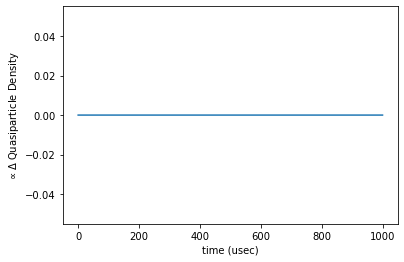

In [5]:
# Plot the raw data
quasiparticle_timestream.plot_timeseries(quasiparticle_timestream.data)

In [6]:
# Define a sudden change in quasiparticle density (caused by a photon)
quasiparticle_timestream.gen_quasiparticle_pulse(tf=30);

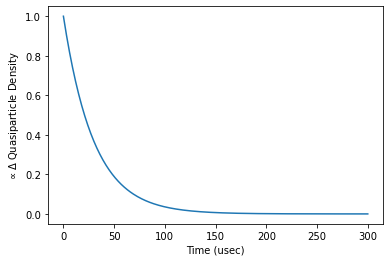

In [7]:
# Plot the pulse
quasiparticle_timestream.plot_pulse()

In [16]:
# Generate photon arrival times
quasiparticle_timestream.gen_photon_arrivals(cps=1000)

array([False, False, False, ..., False, False, False])

In [17]:
# Verify how many photons we got
print(quasiparticle_timestream.photon_arrivals.sum())

1


In [18]:
# Populate phase data with photon pulses
quasiparticle_timestream.populate_photons()

array([0., 0., 0., ..., 0., 0., 0.])

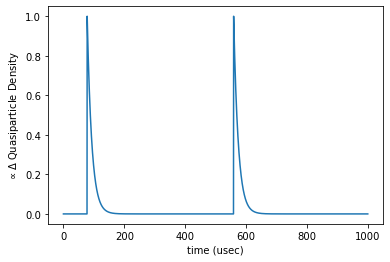

In [19]:
# Plot new timseries data
quasiparticle_timestream.plot_timeseries(quasiparticle_timestream.data)

# Resonator

In [20]:
# Create resonator and compute S21
resonator = Resonator()
rf = RFElectronics()
freq = FrequencyGrid()
sweep = ResonatorSweep(resonator, freq, rf)

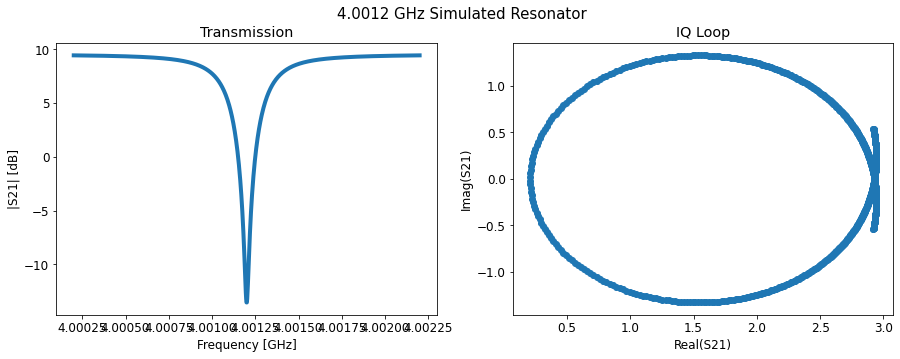

In [21]:
# Plot S21
sweep.plot_sweep()

# Single Photon Event

In [22]:
#Try just one photon and no TLS noise

def pulse(t, t0, tf=30):
    p = np.zeros_like(t)
    p[t >= t0] = -np.exp(-(t[t >= t0] - t0) / tf)
    return p

t = np.linspace(0, 500, 1000)  # in us
photon = pulse(t, 20, tf=30)

qp_timestream_single = copy.deepcopy(quasiparticle_timestream)
qp_timestream_single.tvec = t
qp_timestream_single.data = photon

In [23]:
# Define Measurment Object
lit_res_measurment = ReadoutPhotonResonator(resonator, qp_timestream_single, freq, rf)

In [ ]:
lit_res_measurment.plot_photon_response(sweep.s21)

In [47]:
theta1, d1 = lit_res_measurment.basic_coordinate_transformation()
theta2, d2 = lit_res_measurment.nick_coordinate_transformation()

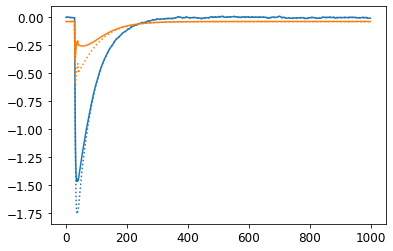

In [48]:
fig, axes = plt.subplots()
axes.plot(theta1, color='C0')
axes.plot(d1, color='C1')
axes.plot(theta2, linestyle=":", color='C0')
axes.plot(d2, linestyle=':', color='C1')

# Try to Look at the Repsonse with Multiple Photons
Now I'm going to perform the same measurment but this time I will use the original `phase_timestream` object with 12 photons.

In [49]:
lit_res_measurment = ReadoutPhotonResonator(resonator, quasiparticle_timestream, freq, rf)

In [ ]:
theta2_many, d2_many = lit_res_measurment.basic_coordinate_transformation()

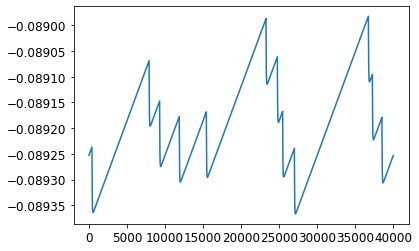

In [25]:
# This does not look how I would expect?
plt.plot(np.angle(lit_res_measurment.iq_response_nonoise))

In [16]:
lit_res_measurment.res.q_tot_0/(np.pi*lit_res_measurment.res.f0_0)

1.110050308804303e-06

In [17]:
lit_res_measurment.res.q_tot_0

13953.488372093023

In [18]:
lit_res_measurment.photons.dt

5.005005005005006e-07

In [19]:
lit_res_measurment.res.f0_0

4001200000.0